In [1]:
from FlowStorm.flow_surface import FlowSurface
from FlowStorm.toy_data import generate_discrete_dataset
from FlowStorm.yield_model import YieldModel_RBF, YieldModel_Poly
from itertools import product
import jax.random as jr
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [70]:
rng = jr.key(187)
N = 1_000_000
base_alpha = 0.
baseline_mu = 0.
baseline_p = .5
baseline_data = generate_discrete_dataset(rng,base_alpha,sigma=1.,p=.5,n=N)
base_alphas = jnp.array([base_alpha]*N)

In [71]:
off_baseline_ps = [.25,.33,.5,.67,.75]
off_baseline_sigma = 1.
off_baseline_mus = [-2.,-1.,0.,1.,2.]
off_baseline_sets = []
off_baseline_alphas = []
for off_baseline_p in off_baseline_ps:
    rng, subkey = jr.split(rng)
    data = generate_discrete_dataset(subkey, baseline_mu, off_baseline_sigma, off_baseline_p, N)
    alphas = jnp.array([[off_baseline_p,baseline_mu]]*len(data))[:,None]
    off_baseline_sets.append(data)
    off_baseline_alphas.append(alphas)

for off_baseline_mu in off_baseline_mus:
    rng, subkey = jr.split(rng)
    data = generate_discrete_dataset(subkey, off_baseline_mu, off_baseline_sigma, baseline_p, N)
    alphas = jnp.array([[baseline_p,off_baseline_mu]]*len(data))[:,None]
    off_baseline_sets.append(data)
    off_baseline_alphas.append(alphas)


x_train = jnp.concatenate(off_baseline_sets)
alpha_train = jnp.concatenate(off_baseline_alphas)

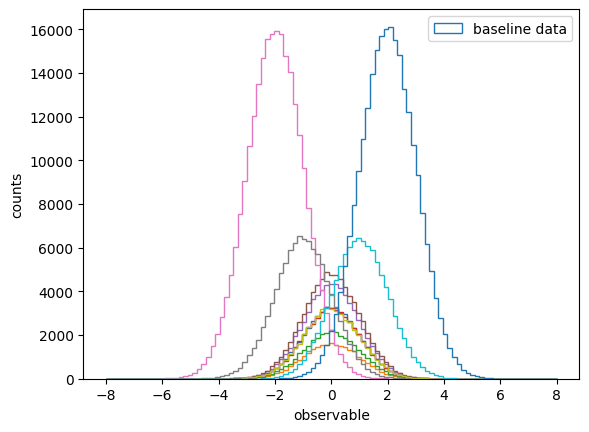

In [72]:
fig ,ax = plt.subplots()
bins = jnp.linspace(-8,8,100)
ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
for off_baseline_set in off_baseline_sets:
    ax.hist(off_baseline_set,bins=bins,histtype="step")
ax.set_xlabel("observable")
ax.set_ylabel("counts")
plt.legend()


In [73]:
yields = [len(x) for x in off_baseline_sets]

In [74]:
yields

[25324, 33248, 49986, 66945, 74943, 250033, 100057, 49723, 99828, 250255]

In [75]:
alphas = [[p,baseline_mu] for p in off_baseline_ps]
alphas += [[baseline_p,mu] for mu in off_baseline_mus]
alphas

[[0.25, 0.0],
 [0.33, 0.0],
 [0.5, 0.0],
 [0.67, 0.0],
 [0.75, 0.0],
 [0.5, -2.0],
 [0.5, -1.0],
 [0.5, 0.0],
 [0.5, 1.0],
 [0.5, 2.0]]

In [76]:
yld = YieldModel_RBF(alphas,yields)

In [77]:
alpha_train = jnp.array(alpha_train)
alpha_train[0]

Array([[0.25, 0.  ]], dtype=float32)

In [78]:
flow = FlowSurface(x_train, alpha_train[:,0])

In [106]:
len(x_train), len(alpha_train)

(1000342, 1000342)

In [79]:
flow.train_flow()

 55%|█████▌    | 55/100 [05:19<04:21,  5.81s/it, train=1.42, val=1.42 (Max patience reached)]


In [85]:
goal_alpha = [0.5,baseline_mu]
base_alpha = [baseline_p, baseline_mu]
reweight = flow.get_weights(baseline_data,jnp.array(base_alpha),jnp.array(goal_alpha))

In [86]:
epsilon = 1

In [87]:
yld = YieldModel_RBF(alphas,yields,kernel="linear",epsilon=epsilon)

In [88]:
yields

[25324, 33248, 49986, 66945, 74943, 250033, 100057, 49723, 99828, 250255]

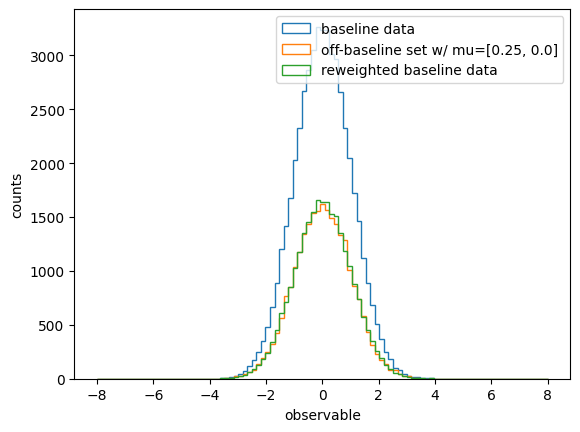

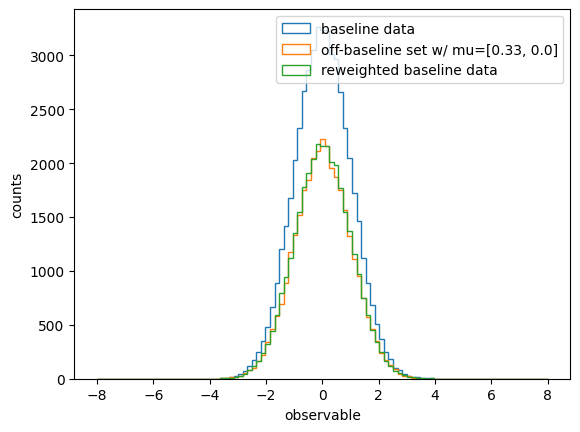

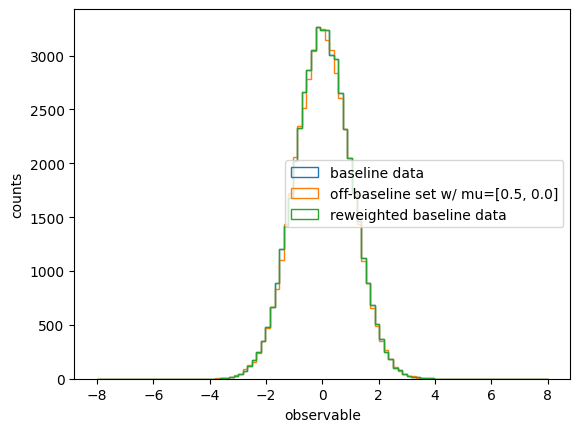

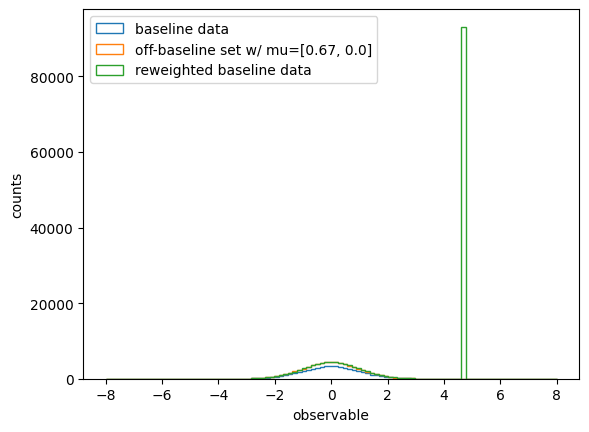

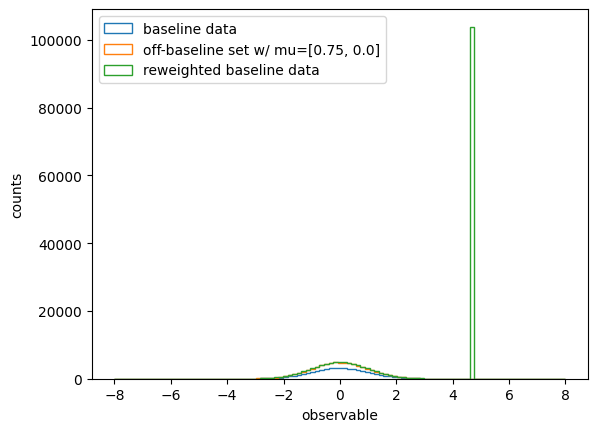

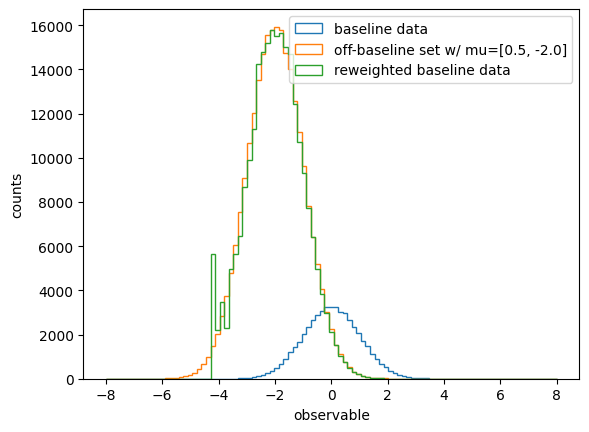

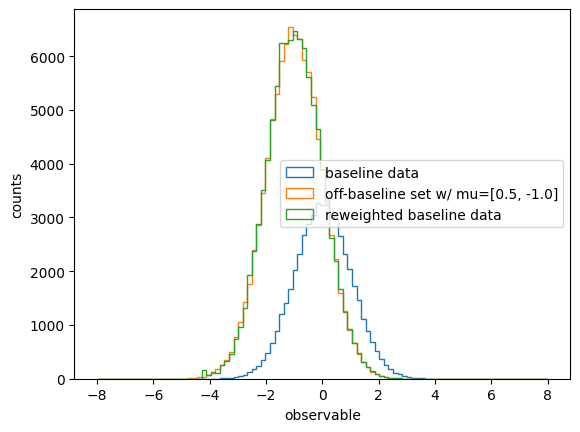

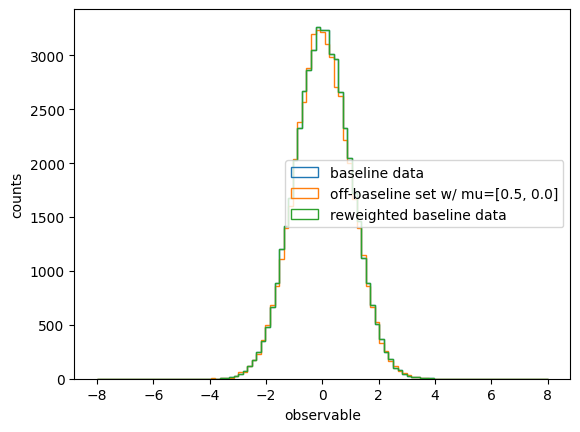

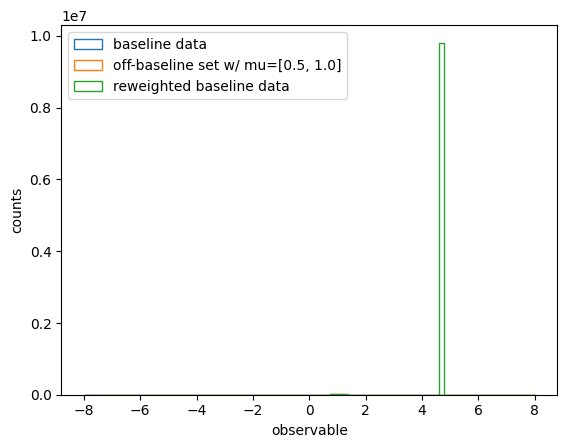

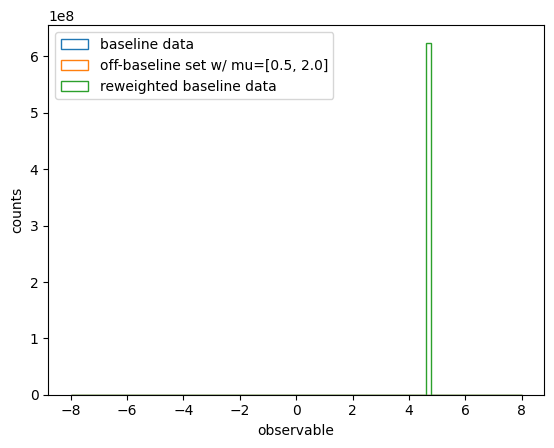

In [89]:
for i,goal_alpha in enumerate(off_baseline_ps):
    goal_alpha = [goal_alpha,baseline_mu]
    base_alpha = [baseline_p, baseline_mu]
    reweight = flow.get_weights(baseline_data,jnp.array(base_alpha),jnp.array(goal_alpha))
    reweight = yld.ratio([base_alpha],[goal_alpha]) * reweight
    fig, ax = plt.subplots()
    bins = jnp.linspace(-8,8,100)
    ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
    ax.hist(off_baseline_sets[i],bins=bins,histtype="step", label=f"off-baseline set w/ mu={goal_alpha}")
    ax.hist(baseline_data,bins=bins,histtype="step",weights=reweight,label="reweighted baseline data")
    ax.set_xlabel("observable")
    ax.set_ylabel("counts")
    plt.legend()


for i,goal_mu in enumerate(off_baseline_mus):
    goal_alpha = [baseline_p, goal_mu]
    base_alpha = [baseline_p, baseline_mu]
    reweight = flow.get_weights(baseline_data,jnp.array(base_alpha),jnp.array(goal_alpha))
    reweight = yld.ratio([base_alpha],[goal_alpha]) * reweight
    fig, ax = plt.subplots()
    bins = jnp.linspace(-8,8,100)
    ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
    ax.hist(off_baseline_sets[i+5],bins=bins,histtype="step", label=f"off-baseline set w/ mu={goal_alpha}")
    ax.hist(baseline_data,bins=bins,histtype="step",weights=reweight,label="reweighted baseline data")
    ax.set_xlabel("observable")
    ax.set_ylabel("counts")
    plt.legend()

In [90]:
from scipy.spatial.distance import pdist
import numpy as onp

def choose_epsilon(alpha_points):
    """
    alpha_points: (K, D)
    Returns a robust ND epsilon scale.
    """
    alpha_points = onp.asarray(alpha_points)
    dists = pdist(alpha_points)  # all pairwise Euclidean distances
    median_dist = onp.median(dists)
    return median_dist

In [91]:
epsilon = choose_epsilon(alphas)
epsilon

np.float64(1.014347080638575)

In [92]:
yld = YieldModel_RBF(alphas,yields,kernel="mq",epsilon=epsilon)

In [93]:
yld.ratio([.5,.0],[.8,-.7])

np.float64(1.46988963573938)

In [94]:
goal_alpha, base_alpha

([0.5, 2.0], [0.5, 0.0])

In [95]:
yld = YieldModel_RBF(alphas,yields,kernel="linear",epsilon=epsilon)

2.297747008116672


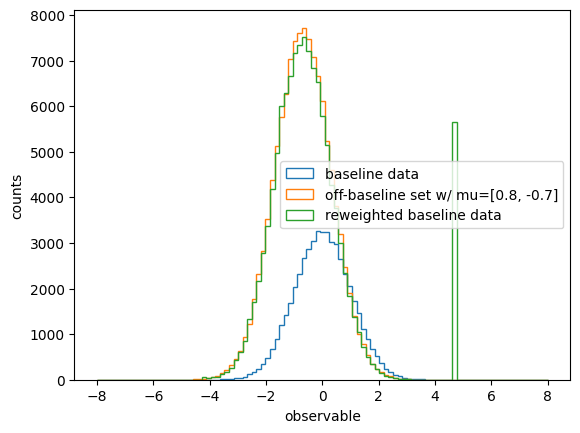

In [105]:
goal_p = .8
goal_mu = -.7
yld = YieldModel_Poly(alphas,yields,degree=4)
goal_alpha = [goal_p,goal_mu]
base_alpha = [baseline_p,baseline_mu]

key, _ = jr.split(rng)
off_baseline_set = generate_discrete_dataset(key,goal_mu,1.,goal_p,N)

reweight = flow.get_weights(baseline_data,jnp.array(base_alpha),jnp.array(goal_alpha))
yield_ratio = yld.ratio([base_alpha],[goal_alpha])
print(yield_ratio)
reweight = yield_ratio * reweight
fig, ax = plt.subplots()
bins = jnp.linspace(-8,8,100)
ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
ax.hist(off_baseline_set,bins=bins,histtype="step", label=f"off-baseline set w/ mu={goal_alpha}")
ax.hist(baseline_data,bins=bins,histtype="step",weights=reweight,label="reweighted baseline data")
ax.set_xlabel("observable")
ax.set_ylabel("counts")
plt.legend()

In [44]:
yld = YieldModel_Poly(alphas,yields,degree=2)

In [45]:
jnp.array(alphas).shape, jnp.array(yields).shape

((10, 2), (10,))

Text(0, 0.5, 'mu')

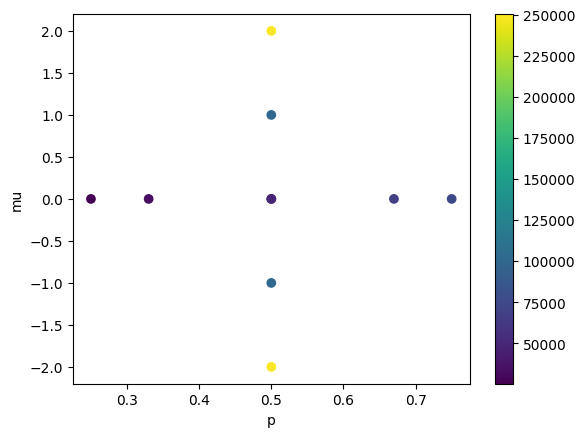

In [97]:
plt.scatter(jnp.array(alphas)[:,0],jnp.array(alphas)[:,1],c=yields)
plt.colorbar()
plt.xlabel("p")
plt.ylabel("mu")

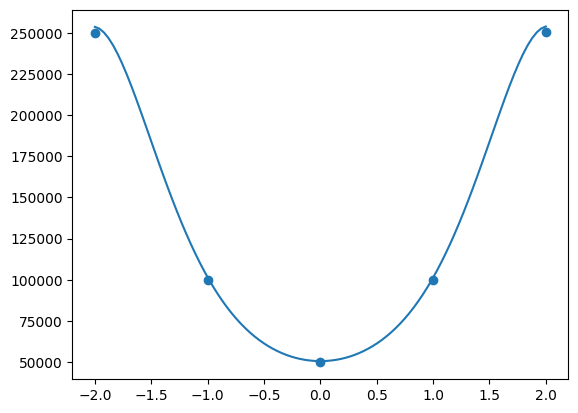

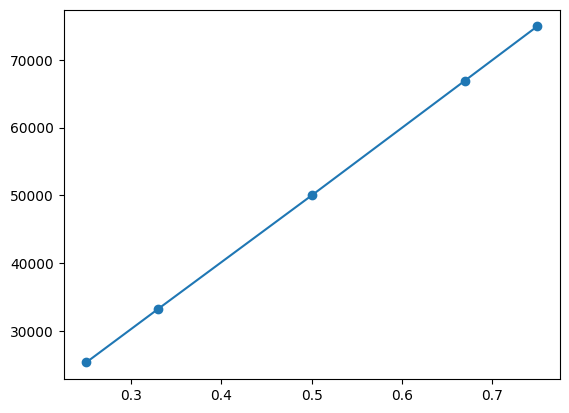

In [104]:
yld = YieldModel_Poly(alphas,yields,degree=4)
# yld = YieldModel_RBF(alphas,yields)
#plt.scatter(off_baseline_ps,yields)

xx = jnp.linspace(onp.min(off_baseline_mus),onp.max(off_baseline_mus),100)
yy = jnp.array([yld.ratio([[.5,0.]],[[0.5,x]]) for x in xx] )* len(baseline_data)
plt.plot(xx,yy)
xx = off_baseline_mus
yy = yields[5:]
plt.scatter(xx,yy)
plt.show()
#plt.scatter(off_baseline_ps,yields)
xx = jnp.linspace(onp.min(off_baseline_ps),onp.max(off_baseline_ps),100)
yy = jnp.array([yld.ratio([[.5,0.]],[[x,0.]]) for x in xx] )* len(baseline_data)
xx = off_baseline_ps
yy = yields[:5]
plt.scatter(xx,yy)
plt.plot(xx,yy)